In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.bezier as bezier
from numpy.polynomial.polynomial import Polynomial

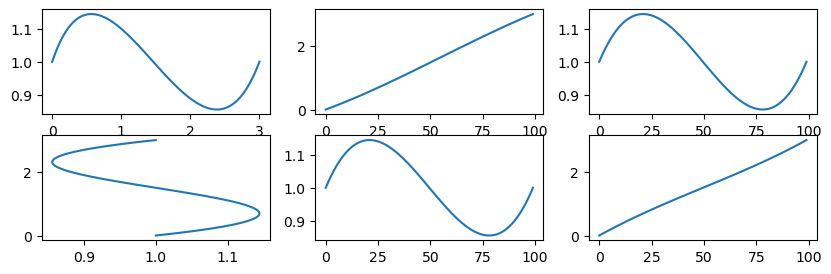

In [32]:
# one_curve = bezier.BezierSegment([[0, 0], [0, 1], [.5, 1.5], [1, 1]])
# other_curve = bezier.BezierSegment([[-0.5, .5], [1, .5], [.5, 1], [2, 2]])
one_curve = bezier.BezierSegment([[0, 1], [.8, 1.5], [2.1, .5], [3, 1]])
other_curve = bezier.BezierSegment([[1, 0], [1.5, 1.2], [.5, 1.8], [1, 3]])

fig, ax = plt.subplots(2,3, figsize=(10, 3))

one_points = np.array(one_curve.point_at_t(np.linspace(0, 1, 100)))
other_points = np.array(other_curve.point_at_t(np.linspace(0, 1, 100)))

ax[0,0].plot(*one_points.T, label='one')
ax[1,0].plot(*other_points.T, label='other')

ax[0,1].plot(one_points.T[0], label='one-x')
ax[1,1].plot(other_points.T[0], label='other-x')

ax[0,2].plot(one_points.T[1], label='one-y')
ax[1,2].plot(other_points.T[1], label='other-y')

0.0 + 2.4000000000000004·x¹ + 1.4999999999999996·x² -
0.8999999999999999·x³ 1.0 + 1.5·x¹ - 4.5·x² + 3.0·x³
[-0.71688693  4.00083755] [1.14433757 0.85566243]
1.0 + 1.5·x¹ - 4.5·x² + 3.0·x³ 0.0 + 3.5999999999999996·x¹ - 1.7999999999999992·x² +
1.1999999999999995·x³
[1.14433757 0.85566243] [1.5-1.55884573j 1.5+1.55884573j]


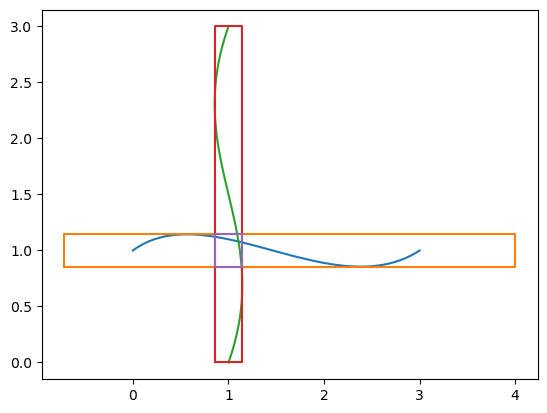

In [33]:
# turning this into a function
def get_bounding_box(curve):
    x_polynomial, y_polynomial = curve.polynomial_coefficients.T # index same as degree
    x_polynomial, y_polynomial = Polynomial(x_polynomial), Polynomial(y_polynomial)
    x_derivative, y_derivative = x_polynomial.deriv(), y_polynomial.deriv()
    (x_begin, y_begin), (x_end, y_end) = curve.point_at_t(0), curve.point_at_t(1)
    x_min, x_max = min(x_begin, x_end), max(x_begin, x_end)
    y_min, y_max = min(y_begin, y_end), max(y_begin, y_end)

    x_roots, y_roots = x_derivative.roots(), y_derivative.roots()
    # x_roots = x_roots[(x_roots >= 0) & (x_roots <= 1)]
    # y_roots = y_roots[(y_roots >= 0) & (y_roots <= 1)]
    print(x_polynomial, y_polynomial)
    x_at_roots = x_polynomial(x_roots)
    y_at_roots = y_polynomial(y_roots)
    print(x_at_roots, y_at_roots)
    x_min, x_max = min(x_min, *x_at_roots), max(x_max, *x_at_roots)
    y_min, y_max = min(y_min, *y_at_roots), max(y_max, *y_at_roots)
    return (x_min, x_max), (y_min, y_max)

# now we can use this function to get the bounding boxes of each curve
one_box = get_bounding_box(one_curve)
other_box = get_bounding_box(other_curve)

# plot the first curve and bounding box
plt.plot(*one_points.T)
plt.plot([one_box[0][0], one_box[0][0], one_box[0][1], one_box[0][1], one_box[0][0]], [one_box[1][0], one_box[1][1], one_box[1][1], one_box[1][0], one_box[1][0]])

# plot the other curve and bounding box
other_points = np.array(other_curve.point_at_t(np.linspace(0, 1, 100)))
plt.plot(*other_points.T)
plt.plot([other_box[0][0], other_box[0][0], other_box[0][1], other_box[0][1], other_box[0][0]], [other_box[1][0], other_box[1][1], other_box[1][1], other_box[1][0], other_box[1][0]])

# get the intersection of the bounding boxes
x_min = max(one_box[0][0], other_box[0][0])
x_max = min(one_box[0][1], other_box[0][1])
y_min = max(one_box[1][0], other_box[1][0])
y_max = min(one_box[1][1], other_box[1][1])

# plot the intersection of the bounding boxes
plt.plot([x_min, x_min, x_max, x_max, x_min], [y_min, y_max, y_max, y_min, y_min])

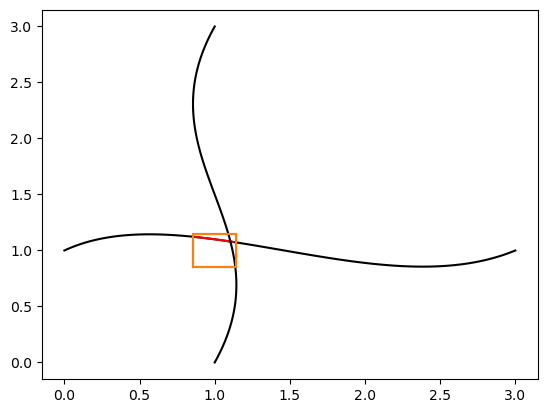

In [34]:
# get the section of the curve that is within the bounding box
one_points = np.array(one_curve.point_at_t(np.linspace(0, 1, 100)))
plt.plot(*one_points.T, c='k')
# print bounding box
plt.plot([x_min, x_min, x_max, x_max, x_min], [y_min, y_max, y_max, y_min, y_min])
one_points = one_points[(one_points.T[0] >= x_min) & (one_points.T[0] <= x_max) & (one_points.T[1] >= y_min) & (one_points.T[1] <= y_max)]
plt.plot(*one_points.T, c='r')

# get the section of the other curve that is within the bounding box
other_points = np.array(other_curve.point_at_t(np.linspace(0, 1, 100)))
plt.plot(*other_points.T, c='k')
# print bounding box
plt.plot([x_min, x_min, x_max, x_max, x_min], [y_min, y_max, y_max, y_min, y_min])

# get the roots of the first curve within the bounding box
x_polynomial, y_polynomial = one_curve.polynomial_coefficients.T # index same as degree
x_polynomial, y_polynomial = Polynomial(x_polynomial), Polynomial(y_polynomial)


